<a href="https://colab.research.google.com/github/doouv/2025-KIChe-PSE-Summer-School-Tutorial/blob/main/Hands_on_practice_EMSRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🚩Introduction**

*   This colab is design to run the [EMSRL](https://github.com/kangdj6358/EMSRL)--reinforcement learning PPO algorithm designed to maximize profits by utilizing battery energy storage systems (BESS) and alkaline water electrolyzers (AWE) to manage curtailed energy generated from solar and wind power.

*   This tutorial utilizes the actual EMSRL code while providing a demo preset that resolves compatibility issues.

*   This colab was prepared for **the 2025 KiChe PSE Summer School** by TA [Hayoung Doo](https://github.com/doouv/2025-KIChe-PSE-Summer-School-Tutorial) with academic supervision from [Prof. Jonggeol Na](https://nagroup.ewha.ac.kr/), based on the origianl code and paper.


> **Paper:** [D. Kang *et al*., Energy 284 (2023) 128623](https://www.sciencedirect.com/science/article/pii/S0360544223020170?via%3Dihub#fig1)

---
\
<img src=https://ars.els-cdn.com/content/image/1-s2.0-S0360544223020170-gr1_lrg.jpg width=750>
## **🎯 Problem description**
*   In modern power grids, surplus renewable energy (e.g., from solar or wind) is often wasted if not stored. This is known as curtailment, which represents a significant economic loss.
*   To utilize this excess energy effectively, an optimal scheduling strategy for charging and discharging energy storage systems (ESS) and operating electrolyzers is required.
*    **Goal:** To develop a control policy that schedules ESS operations and electrolyzer usage to **maximize energy utilization and economic benefit** while respecting operational constraints such as:

  *   Battery capacity and power limits
  *   Electrolyzer minimum/maximum operating ranges
  *   Energy conversion efficiencies
  *   Real-time electricity prices

# **📥 Installations**

### Git clone

In [ ]:
!git clone https://github.com/kangdj6358/EMSRL.git
%cd EMSRL

Cloning into 'EMSRL'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 170 (delta 93), reused 134 (delta 57), pack-reused 0 (from 0)
Receiving objects: 100% (170/170), 3.89 MiB | 9.12 MiB/s, done.
Resolving deltas: 100% (93/93), done.
/content/EMSRL


### Install RL framework libraries

In [ ]:
!pip install ray[rllib]
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 11.6 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.0
    Uninstalling gymnasium-1.2.0:
      Successfully uninstalled gymnasium-1.2.0


### Dataset overview

In [ ]:
import pandas as pd

df_raw = pd.read_excel('./dataset/2021_revised.xlsx')
df_raw.head()

,Time,Ps+Pw,47086.09,855795.52,2021 (Wind),2021 (Solar),Unnamed: 6,Wind Frac,Solar Frac,Unnamed: 9,Unnamed: 10,Unnamed: 11,elec_price
0,8761.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,310
1,8762.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,310
2,8763.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,310
3,8764.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,310
4,8765.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,310


The dataset is currently in a raw, unprocessed state. To address this, we extract and organize only the necessary variables to create a clean, structured dataset.

📢 While this preprocessing step is originally implemented **within the environment class** in the source code, we have moved it outside **to show how the dataset is** and to allow for easier inspection of the processed data.

**Key variables**

*   `Time`: Hourly timestamps
*   `2021 (Wind)`: Wind power generation (MW)
*   `2021 (Solar)`: Solar power generation (MW)
*   `elec_price`: Electricity market price ($/MWh)

In [ ]:
cols = ["Time", "2021 (Wind) ", "2021 (Solar) ", "elec_price"]
df = df_raw[cols].copy()

period = len(df)-24  # default: 1yr = 365day * 24day/hr = 8760hr; 24hours of past data
wind_frac  = 0.05
solar_frac = 0.05

# Timeseries
wind  = (df["2021 (Wind) "].values)[:period+48]  * wind_frac
solar = (df["2021 (Solar) "].values)[:period+48] * solar_frac

ELEC  = df["elec_price"].values   # 24hr slice rule
ELEC_cost = ELEC[24:period+48]

df.head(30)

,Time,2021 (Wind),2021 (Solar),elec_price
0,8761.0,0.000000,0.000000,310
1,8762.0,0.000000,0.000000,310
2,8763.0,0.000000,0.000000,310
3,8764.0,0.000000,0.000000,310
4,8765.0,0.000000,0.000000,310
5,8766.0,0.000000,0.000000,310
6,8767.0,0.000000,0.000000,310
7,8768.0,0.000000,0.000000,310
8,8769.0,397.509009,6.382029,290
9,8770.0,255.785929,431.361431,290


# **🌏 Environment setting**
The code below is the migrated version of `"./environment/env_2021_EP.py"` with Gymnasium compatibility.

**Key components of the environment:**

*   **State space:** Contains SOC (State of Charge), remaining ESS capacity, past 24h electricity/H2 prices, and future 24h renewable generation forecast
*   **Action space:** Continuous actions for ESS charge/discharge power and AWE operation level
*   **Reward function:** Based on profit from electricity arbitrage and hydrogen production minus operational costs


| 번호 | 수식  | 설명 |
|------|--------------|------|
| 1 | $$CF_t \times \left( P^W_t + P^S_t \right) = P^A_t + P^{CH}_t$$ | 전력 흐름 균형식 |
| 2 | $$0 \le CF_t \le 1$$ | 전력 절감 비율 한계 |
| 3 | $$z^{CH}_t + z^{DH}_t \le 1$$ | 충방전 동시 불가 조건 |
| 4 | $$z^{CH}_t \times P_{BESS,\mathrm{MIN}} \le P^{CH}_t \le z^{CH}_t \times P_{BESS,\mathrm{MAX}}$$ | 충전 전력 범위 |
| 5 | $$z^{DH}_t \times P_{BESS,\mathrm{MIN}} \le P^{DH}_t \le z^{DH}_t \times P_{BESS,\mathrm{MAX}}$$ | 방전 전력 범위 |
| 6 | $$SOC_t CAP_{BESS} = SOC_{t-1} CAP_{BESS} + P^{CH}_t \Delta t \eta_{CH} - \frac{P^{DH}_t \Delta t}{\eta_{DH}}$$ | SOC 갱신식 |
| 7 | $$\alpha \le SOC_t \le 1$$ | SOC 범위 제약 |
| 8 | $$z^{AWE}_t \times P_{AWE,\mathrm{MIN}} \le P^A_t \le z^{AWE}_t \times P_{AWE,\mathrm{MAX}}$$ | 수전해 전력 범위 |
| 9 | $$P_{AWE,\mathrm{MIN}} = \beta \times P_{AWE,\mathrm{MAX}}$$ | 수전해 최소-최대 전력 비율 |
| 10 | $$H^{AWE}_t = P^A_t \times \left( \frac{\eta_{AWE}}{LHV} \right)$$ | 수전해 수소 생산량 |
| 11 | $$REV = \sum_{t=1}^{T} P^{DH}_t \Delta t S_{DH} + \sum_{t=1}^{T} H^{AWE}_t \Delta t S_{H_2}$$ | 총 수익 계산 |
| 12 | $$PF = REV - \left( CO\&M_{BESS} + CACC_{BESS} + CO\&M_{AWE} + CACC_{AWE} \right)$$ | 총 이익 계산 |
| 13 | $$L_{CLIP}(\theta) = \mathbb{E}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \; \mathrm{clip}( r_t(\theta), 1 - \epsilon, 1 + \epsilon ) \hat{A}_t \right) \right]$$ | PPO 손실함수 |
| 14 | $$\mathrm{clip}( r_t(\theta), 1 - \epsilon, 1 + \epsilon ) = \begin{cases} 1 - \epsilon, & r_t(\theta) \ge 1 - \epsilon \\ 1 + \epsilon, & r_t(\theta) \le 1 + \epsilon \end{cases}$$ | 클리핑 연산 정의 |
| 15 | $$r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\mathrm{old}}}(a_t|s_t)}$$ | 정책 비율 |
| 16 | $$s^{IP}_t = \{ SOC_t, \; P_{(t-24, t-1)}, \; S_{DH\,(t-24, t-1)}, \; S_{H_2\,(t-24, t-1)} \}$$ | IP 단계 상태공간 |
| 17 | $$s^{EP}_t = \{ SOC_t, \; P_{(t, t+23)}, \; S_{DH\,(t-24, t-1)}, \; S_{H_2\,(t-24, t-1)} \}$$ | EP 단계 상태공간 |
| 18 | $$a_t = \{ P^{CH/DH}_t, \; P^A_t \}$$ | 행동공간 |
| 19 | $$REV_t = P^{DH}_t \Delta t S_{DH} + H^{AWE}_t \Delta t S_{H_2}$$ | 시점별 수익 |
| 20 | $$PF_t = REV_t - \frac{CO\&M + CACC}{T}$$ | 시점별 이익 |
| 21 | $$CO\&M = CVOM + CFO$$ | 운영비 계산 |
| 22 | $$PF_t = REV_t - CVOM_t - \frac{CFO + CACC}{T}$$ | 시점별 이익 (세부) |
| 23 | $$\mathcal{P}_t = \begin{cases} P^{CH}_t \Delta t - (1 - SOC_t) CAP_{BESS}, & \text{if } P^{CH}_t \Delta t \ge (1 - SOC_t) CAP_{BESS} \\ P^{DH}_t \Delta t - (SOC_t - SOC_{\min}) CAP_{BESS}, & \text{if } P^{DH}_t \Delta t \ge (SOC_t - SOC_{\min}) CAP_{BESS} \\ 0, & \text{otherwise} \end{cases}$$ | 벌칙 함수 |
| 24 | $$r_t = PF_t - \mathcal{P}_t \times \mathcal{F}$$ | 보상함수 1 |
| 25 | $$r_t = REV_t - CVOM_t - \frac{CFO + CACC}{T} - \mathcal{P}_t \times \mathcal{F}$$ | 보상함수 2 |
| 26 | $$OBJ = \sum_{t=1}^{T} \left( REV_t - CVOM_t - \frac{CFO + CACC}{T} - \mathcal{P}_t \times \mathcal{F} \right)$$ | 목적함수 |


In [ ]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from copy import copy

class EMSRLEnv(gym.Env):

    def __init__(self, *args, **kwargs):

        # ===== Defaults =====
        # 여기선 이해를 위해 한국어로✋
        self.period = 8760
        self.wind_frac = 0.05   # (1),(2) CF_t 관련: 커트일 비율은 데이터 스케일링으로 간접 반영
        self.solar_frac = 0.05  # (1),(2) cf. 명시적 CF_t 변수는 없음
        self.ESS_cap = 1500     # [MWh]

        self.ESS_eff = 0.95     # (6) η_CH ≈ η_DH 로 단일 효율로 단순화
        self.AWE_eff = 0.68     # (10) η_AWE

        self.H2_cost = 6        # (11),(19) S_H2 [$ / kg]

        # (4),(5) BESS 전력 한계: 0.3C 가정 → P_BESS,MAX = 0.3 * CAP
        self.ESS_P_cap = self.ESS_cap * 0.3

        self.AWE_P_cap = 200    # (8),(9) AWE 전력 한계 (MIN은 β*MAX 로 아래에서 설정)

        # (21),(22) VOM/FOM, (12) CACC 산출에 쓰이는 비용 파라미터들
        self.VOM = 30
        self.FOM = 10000
        self.BESS_power_cost = 483000
        self.BESS_capacity_cost = 148000
        self.AWE_cost = 630000
        self.number_of_years = 10
        self.inflation_rate = 0.045  # (12) 연평준화에 사용 (CRF 유사)

        # ===== Override via kwargs ("env_config") =====
        for k, v in kwargs.items():
            setattr(self, k, v)

        # ===== Formulars =====
        # (12) CAPEX 구성요소: BESS/AWE CAPEX (원가) → 연평준(annuity)로 변환하여 per-step로 차감
        self.BESS_cos = self.ESS_cap * self.BESS_capacity_cost + self.ESS_P_cap * self.BESS_power_cost
        self.AWE_cos = self.AWE_cost * self.AWE_P_cap
        # (12) Annualized capital cost (CACC): r/((1+r)^n - 1) 사용
        self.BESS_ann = self.BESS_cos * self.inflation_rate / ((1 + self.inflation_rate) ** self.number_of_years - 1)
        self.AWE_ann = self.AWE_cos * self.inflation_rate / ((1 + self.inflation_rate) ** self.number_of_years - 1)

        # ===== Data load (same process with the previous cell) =====
        data_path = '/content/EMSRL/dataset/2021_revised.xlsx'
        df = pd.read_excel(data_path)

        # (1) PwPs_t = P^W_t + P^S_t (여기서는 wind_frac/solar_frac 곱으로 CF/스케일 반영)
        self.df_wind = df["2021 (Wind) "][0:self.period + 48] * self.wind_frac
        self.df_solar = df["2021 (Solar) "][0:self.period + 48] * self.solar_frac
        self.ELEC_cost = df["elec_price"][24:self.period + 48]   # (19) S_DH
        self.ELEC_cost = self.ELEC_cost.to_numpy()

        # ===== Uncertainty injection =====
        # (4.2 평가 파트 맥락) 불확실성 주입 (수식 번호 없음: 실험 설정)
        wind_uncertain = np.random.normal(1, 0, size=self.period + 48)
        solar_uncertain = np.random.normal(1, 0, size=self.period + 48)
        df_wind_uncer = self.df_wind * wind_uncertain
        df_solar_uncer = self.df_solar * solar_uncertain
        df_PwPs = df_wind_uncer + df_solar_uncer

        self.PwPs = list(np.array(df_PwPs.tolist()))  # (1) 총 커트일 전력

        # ===== Env state =====
        self.num_energy = 1
        # (7) α ≤ SOC_t ≤ 1 구현: α=0.05를 용량에서 제외 (ESS_capacity=0.95*CAP)
        self.ESS_capacity = self.ESS_cap * 0.95  # except ESS min
        self.step_limit = self.period + 24  # Curtailed data period (Δt=1 가정)

        self.ESS_cap_remain = copy(self.ESS_capacity)

        self.action_acc = []
        self.ESS_charge = []
        self.ESS_discharge = []
        self.AWE_acc = []
        self.profit = []

        self.step_sell_reward = 0
        self.total_sell_reward = 0

        self.ELEC_sell = 0
        self.ELEC_store = 0
        self.H2_sell = 0

        self.TBOM = 0
        self.H = 0
        self.TAOM = 0

        # (16),(17) 상태 설계 관련: 과거 24h 가격, 미래 24h 커트일 전력 포함 → EP 상태에 해당
        ELECmean = self.ELEC_cost
        asset1mean = ELECmean.reshape(1, -1)
        asset1var = np.ones(asset1mean.shape) * ELECmean * 0
        H2mean = np.ones(self.period + 24) * self.H2_cost
        asset2mean = H2mean.reshape(1, -1)
        asset2var = np.ones(asset2mean.shape) * 4.5 * 0
        self.asset_price_means = np.vstack([asset1mean, asset2mean])
        self.asset_price_var = np.vstack([asset1var, asset2var])

        # (17) 관측 차원: SOC, 잔여용량, 과거 24h 가격*2, 미래 24h PwPs → 총 74
        self.obs_length = 74

        self.observation_space = spaces.Box(-3000000, 40000000, shape=(self.obs_length,))

        # (8),(9),(18) 행동공간: [P^{CH/DH}_t, P^A_t], AWE 하한=0.2*P_max (β=0.2)
        self.action_space = spaces.Box(low=np.array([-self.ESS_P_cap, self.AWE_P_cap * 0.2]),
                                       high=np.array([self.ESS_P_cap, self.AWE_P_cap]), shape=(2,))
        self.reset()

    def _RESET(self):
        self.step_count = 24
        self.asset_price_ELEC = self.ELEC_cost   # (19) S_DH
        self.asset_price_H2 = np.ones(self.period + 24) * self.H2_cost  # (19) S_H2
        self.SOC = np.zeros(self.num_energy)
        self.ESS_cap_remain = copy(self.ESS_capacity)

        # (17) EP 상태: SOC_t, ESS_cap_remain, 과거 24h 가격(전기/수소), 미래 24h PwPs
        self.state = np.hstack([
            np.array(self.SOC),
            np.array([self.ESS_cap_remain]),
            self.asset_price_ELEC[self.step_count - 24:self.step_count],
            self.asset_price_H2[self.step_count - 24:self.step_count],
            self.PwPs[self.step_count:self.step_count + 24]
        ])

        self.action_acc = []
        self.ESS_charge = []
        self.ESS_discharge = []
        self.AWE_acc = []
        self.profit = []

        self.step_sell_reward = 0
        self.total_sell_reward = 0

        self.ELEC_sell = 0
        self.ELEC_store = 0
        self.H2_sell = 0

        self.TBOM = 0
        self.H = 0
        self.TAOM = 0

        # Gymnasium requires returning info dict
        info = {
            'step_count': self.step_count,
            'ESS_cap_remain': self.ESS_cap_remain,
            'SOC': self.SOC[0]
        }

        return self.state, info

    def _generate_asset_prices(self):
        # (수식 직접 대응 없음) 실험용 랜덤 가격 생성
        asset_prices = np.array([np.random.normal(mu, sig) for mu, sig in
                                 zip(self.asset_price_means.flatten(), self.asset_price_var.flatten())]
                                ).reshape(self.asset_price_means.shape)

        zero_vals = np.vstack(np.where(asset_prices < 0))
        cols = np.unique(zero_vals[0])
        for c in cols:
            first_zero = zero_vals[1][np.where(zero_vals[0] == c)[0].min()]
            asset_prices[c, first_zero:] = 0
        asset_prices_ELEC = asset_prices[0]
        asset_prices_H2 = asset_prices[1]
        return asset_prices_ELEC, asset_prices_H2

    def _STEP(self, action):

        self.action_acc.extend([action])

        assert self.action_space.contains(action)

        ESS_action = action[0]
        AWE_active = action[1]

        if ESS_action == 0:
            binary = 0   # (3) z_CH+z_DH≤1 대체: 0=휴지

        elif ESS_action < 0:
            binary = 0   # (3) 방전 분기 (z_DH=1, z_CH=0에 상응)
            ESS_action = -1 * ESS_action

            # (5) BESS 방전 상·하한 제약 (SOC 기반), (7) SOC 하한
            if ESS_action > self.SOC[0] * self.ESS_eff:
                ESS_action = self.SOC[0] * self.ESS_eff
            else:
                pass

            self.ELEC_sell = ESS_action
            # (6) SOC 동역학: 방전 (Δt=1 가정, η_DH=ESS_eff)
            self.ESS_cap_remain += ESS_action / self.ESS_eff
            self.SOC[0] -= ESS_action / self.ESS_eff

            if self.SOC[0] < 0:   # (7) SOC ≥ 0
                self.SOC[0] = 0

        else:  # ESS_action > 0 → 충전
            binary = 1   # (3) 충전 분기 (z_CH=1, z_DH=0에 상응)

            # (1) PwPs 한계 내에서 충전 우선 할당, (4) BESS 충전 상·하한 제약
            if ESS_action > self.PwPs[self.step_count]:
                ESS_action = self.PwPs[self.step_count]
            else:
                pass

            if ESS_action > self.ESS_cap_remain / self.ESS_eff:
                ESS_action = self.ESS_cap_remain / self.ESS_eff
            else:
                pass

            self.ELEC_store = ESS_action
            # (6) SOC 동역학: 충전 (Δt=1, η_CH=ESS_eff)
            self.ESS_cap_remain -= ESS_action * self.ESS_eff
            self.SOC[0] += ESS_action * self.ESS_eff

        # (8),(9) AWE 전력 제약 및 최소가동조건(β=0.2), (1) 남은 에너지로 AWE 가동
        if self.PwPs[self.step_count] - binary * ESS_action < self.AWE_P_cap * 0.2:
            AWE_active = 0
        elif AWE_active > self.PwPs[self.step_count] - binary * ESS_action:
            AWE_active = self.PwPs[self.step_count] - binary * ESS_action
        else:
            pass

        self.H2_sell = AWE_active

        # (10) H_t = P^A_t * (η_AWE/LHV) 를 수익 계산에 사용, (19) REV_t
        self.step_sell_reward = self.ELEC_sell * self.ELEC_cost[self.step_count] \
            + self.H2_sell * self.AWE_eff / 0.0333 * self.H2_cost  # LHV=33.3 kWh/kg
        self.total_sell_reward += self.step_sell_reward

        # (21),(22) 시점 VOM 분해: TBOM(BESS), TAOM(AWE)
        self.TBOM = self.ELEC_store * 30
        self.H = self.H2_sell * self.AWE_eff / 0.0333  # (10) 생산량(kg)
        self.TAOM = 10.11 * 0.012 * self.H + 0.0019 * 2.96 * self.H + 0.11 * 0.012 * self.H + 0.00029 * 0.33 * self.H

        # (20),(25) PF_t = REV_t - CVOM_t - (CFO + CACC)/T  → reward로 사용
        # (12) CACC, CFO 포함. (23)-(25) 벌칙항(℘_t·ℱ)은 미구현(→ 본 코드는 행동 클램핑으로 과행동 방지)
        reward = (self.step_sell_reward - self.TBOM - self.TAOM - (
                self.BESS_ann + self.AWE_ann + self.ESS_P_cap * self.FOM + 0.05 * self.AWE_P_cap * self.AWE_cost) / self.step_limit) / 100000

        self.step_count += 1

        # 로깅(수식 직접 대응 없음)
        self.ESS_discharge.extend([self.ELEC_sell])
        self.ESS_charge.extend([self.ELEC_store])
        self.AWE_acc.extend([self.H2_sell])
        self.profit.extend([self.total_sell_reward])

        # Gymnasium distinguishes between terminated and truncated
        terminated = False  # Episode ends due to terminal state
        truncated = False   # Episode ends due to time limit

        if self.step_count >= self.step_limit:
            truncated = True
        else:
            self._update_state()

        # info (수식 직접 대응 없음: 디버깅용)
        info = {
            'step_sell_reward': self.step_sell_reward,
            'total_sell_reward': self.total_sell_reward,
            'ELEC_sell': self.ELEC_sell,
            'ELEC_store': self.ELEC_store,
            'H2_sell': self.H2_sell,
            'SOC': self.SOC[0],
            'ESS_cap_remain': self.ESS_cap_remain,
            'step_count': self.step_count
        }

        return self.state, reward, terminated, truncated, info

    def _update_state(self):
        # (17) EP 상태 갱신
        self.state = np.hstack([
            np.array(self.SOC),
            np.array([self.ESS_cap_remain]),
            self.asset_price_ELEC[self.step_count - 24:self.step_count],
            self.asset_price_H2[self.step_count - 24:self.step_count],
            self.PwPs[self.step_count:self.step_count + 24]
        ])
        # 시점 종료 후 초기화 (수식 직접 대응 없음)
        self.step_sell_reward = 0
        self.ELEC_sell = 0
        self.ELEC_store = 0
        self.H2_sell = 0

        self.TBOM = 0
        self.H = 0
        self.TAOM = 0

    # (18) a_t = {P^{CH/DH}_t, P^A_t} → step(action)으로 전달
    def step(self, action):
        return self._STEP(action)

    def reset(self, *, seed=None, options=None):
        # Gymnasium reset can accept seed and options
        super().reset(seed=seed)
        return self._RESET()


# **⚙️ Problem scale reduction**

In [ ]:
# 원본의 스케일이 너무 크기에, 문제 축소를 위해 아래와 같이 파라미터를 변경했습니다.

env_config = {
    "period": 120,               # 에피소드 (8760시간 -> 120시간(5일))
    "wind_frac": 0.05,           # 풍력 비율
    "solar_frac": 0.05,          # 태양광 비율
    "ESS_cap": 300,              # ESS 용량 (1500->300)
    "ESS_eff": 0.95,             # ESS 효율
    "AWE_eff": 0.68,             # 수전해 효율
    "H2_cost": 6,                # 수소 판매 단가
    "ESS_P_cap": 90,             # ESS 최대 출력
    "AWE_P_cap": 120,            # 수전해 최대 출력
    "number_of_years": 10,       # 투자비 회수 기간
    "inflation_rate": 0.045,     # 할인율
    # ====scale refactor====
    # 아래 계산 식을 참고
    "BESS_power_cost": 7939.6,   # ESS 전력비용
    "BESS_capacity_cost": 2432.9,
    "AWE_cost": 10356.2,
    "FOM": 164.4,
}

## 🤔 **Why We Apply a Scale Factor for Cost Parameters in the 5-Day Version?**

### Original Behavior
- The environment calculates **annual (8760h) capital and fixed O&M costs**.
- It then divides those annual costs by `step_limit` (episode length) to get **hourly costs**.

### Problem When Reducing to 5 Days
- Original setup: step_limit ≈ 8760 + 24
- 5-day setup: step_limit = 120 + 24 = 144
- If we keep original cost parameters, the code does:
      hourly cost = annual cost / 144
  → This makes the **hourly cost much larger** than in the 1-year case.

### Solution: Apply a Scale Factor
- We multiply the cost parameters by:
      scale = step_limit / 8760 = 144 / 8760 ≈ 0.01644
- This reduces the annual costs so that after dividing by step_limit,
  the resulting hourly cost matches the 1-year case.

### Effect of Scaling
    (Annual cost × scale) / step_limit = (Original annual cost) / 8760
→ **Hourly cost burden stays consistent** between the 5-day and 1-year versions.

### In Short...
Scaling ensures that even in the shortened 5-day environment,
the **units and magnitude of hourly costs** remain identical to the original 1-year setup.


# **🖥️ Training**

<img src=https://ars.els-cdn.com/content/image/1-s2.0-S0360544223020170-gr2_lrg.jpg width=600>

The figure above shows the PPO algorithm architecture used in EMSRL. The actor network outputs continuous actions for ESS and AWE control, while the critic network estimates the value function for policy improvement.

## Set training parameters

In [ ]:
import ray
from ray import tune
from ray.rllib.algorithms.ppo import PPO
from ray.tune.registry import register_env as ray_register_env

episode = "EMSRL_EP_2021"
env_name = 'EMSRLEnv'

rl_config = dict(
    env=env_name,
    num_workers=1,
    num_gpus=1,
    env_config=env_config,
    lr=3e-5,
    kl_coeff=0.2,
    clip_param=0.3,
    framework='torch',
    train_batch_size=8000,
    model=dict(
        fcnet_hiddens=[256, 256, 256],
        fcnet_activation="tanh",
    ),
    # Disable new API to avoid compatibility warnings
    _enable_new_api_stack=False,
    enable_rl_module_and_learner=False,
    enable_env_runner_and_connector_v2=False,

)

Register environment

In [ ]:
def env_creator(env_config):
    return EMSRLEnv(**env_config)

# Register environment
ray_register_env(env_name, env_creator)

## Environment test
Let's verify the environment is working correctly before training.

In [ ]:
test_env = env_creator(env_config)
print("Observation space:", test_env.observation_space)
print("Action space:", test_env.action_space)
test_env.reset()
test_env.close()

Observation space: Box(-3000000.0, 40000000.0, (74,), float32)
Action space: Box([-90.  24.], [ 90. 120.], (2,), float32)


/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(


GPU check ✅

In [ ]:
import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch version: 2.6.0+cu124
CUDA available: True


## Create agent and start training!

In the previous tutorial, we adopted a **manual iterative training loop**,
where the `agent.train()` method was called repeatedly inside a Python loop
(e.g., 50 iterations) and the results were stored or printed at fixed intervals.  
In this problem, however, we aim to use `analysis` to enable more systematic tracking
and refined analysis of the training process.

This process will take a little more time😴

In [ ]:
analysis = tune.run(
    "PPO",
    name="EMSRL_EP_2021",
    storage_path="/content/EMSRL/results",
    config=rl_config,
    stop={"training_iteration": 15},   # Train for 15 iteration (~8 min)
    verbose=1,
    checkpoint_at_end=True
)

2025-08-13 15:25:34,352	INFO worker.py:1927 -- Started a local Ray instance.
2025-08-13 15:25:36,269	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within

+--------------------------------------------------------+
| Configuration for experiment     EMSRL_EP_2021         |
+--------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator |
| Scheduler                        FIFOScheduler         |
| Number of trials                 1                     |
+--------------------------------------------------------+

View detailed results here: /content/EMSRL/results/EMSRL_EP_2021
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-08-13_15-25-32_676674_291/artifacts/2025-08-13_15-25-36/EMSRL_EP_2021/driver_artifacts`

Trial status: 1 PENDING
Current time: 2025-08-13 15:25:36. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------+
| Trial name                 status   |
+-------------------------------------+
| PPO_EMSRLEnv_c2dd4_00000   PENDING  |
+-----------------------

(pid=866) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=866) E0000 00:00:1755098739.211453     866 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=866) E0000 00:00:1755098739.222333     866 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=866) W0000 00:00:1755098739.245079     866 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=866) W0000 00:00:1755098739.245113     866 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=866) W0000 00:00:1755098739.245117     866 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the sam

Trial status: 1 PENDING
Current time: 2025-08-13 15:26:06. Total running time: 30s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------+
| Trial name                 status   |
+-------------------------------------+
| PPO_EMSRLEnv_c2dd4_00000   PENDING  |
+-------------------------------------+

Trial PPO_EMSRLEnv_c2dd4_00000 started with configuration:
+-----------------------------------------------------------+
| Trial PPO_EMSRLEnv_c2dd4_00000 config                     |
+-----------------------------------------------------------+
| _enable_new_api_stack                               False |
| clip_param                                            0.3 |
| enable_env_runner_and_connector_v2                  False |
| enable_rl_module_and_learner                        False |
| env                                              EMSRLEnv |
| env_config/AWE_P_cap                                  120 |
| env_config/AWE_cost 

(PPO pid=866) Trainable.setup took 20.847 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=866) Install gputil for GPU system monitoring.
(PPO pid=866) 2025-08-13 15:26:23,079	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!



Trial status: 1 RUNNING
Current time: 2025-08-13 15:26:37. Total running time: 1min 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------+
| Trial name                 status   |
+-------------------------------------+
| PPO_EMSRLEnv_c2dd4_00000   RUNNING  |
+-------------------------------------+
Trial status: 1 RUNNING
Current time: 2025-08-13 15:27:07. Total running time: 1min 30s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       iter     total time (s)     ts     num_healthy_workers     ...anding_async_reqs     ...e_worker_restarts     ...ent_steps_sampled |
+-------------------------------------------------------------------------------------------------------------------------

2025-08-13 15:33:40,471	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/EMSRL/results/EMSRL_EP_2021' in 0.0132s.



Trial PPO_EMSRLEnv_c2dd4_00000 completed after 15 iterations at 2025-08-13 15:33:40. Total running time: 8min 3s
+---------------------------------------------------+
| Trial PPO_EMSRLEnv_c2dd4_00000 result             |
+---------------------------------------------------+
| env_runners/episode_len_mean                  120 |
| env_runners/episode_return_mean           3.77814 |
| num_env_steps_sampled_lifetime             120000 |
+---------------------------------------------------+

Trial status: 1 TERMINATED
Current time: 2025-08-13 15:33:40. Total running time: 8min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         iter     total time (s)       ts     num_healthy_workers     ...anding_async_reqs     ...e_worker_restarts     ...ent_

(PPO pid=866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/EMSRL/results/EMSRL_EP_2021/PPO_EMSRLEnv_c2dd4_00000_0_2025-08-13_15-25-36/checkpoint_000000)


# **📉 Training result-Reward curve**






Load progress.csv file, which records all of changes throughout the entire iteration.

In [ ]:
from pathlib import Path

logdir = Path(analysis.trials[0].local_path)
progress = pd.read_csv(logdir / "progress.csv")

/tmp/ipython-input-2551828642.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


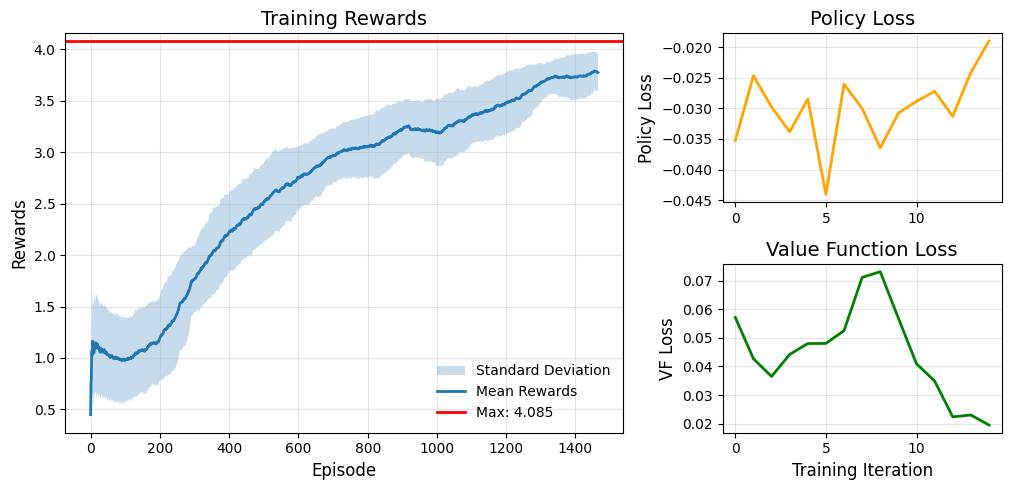

Total episodes: 1466
Max reward: 4.085 at episode 1437
Mean reward: 2.771


In [ ]:
import matplotlib.pyplot as plt
import ast
import re

# progress['env_runners/hist_stats/episode_reward'] -> 'str'
def parse_episode_rewards(reward_str):
    # np.float64() -> numbers
    cleaned_str = re.sub(r'np\.float64\(([-\d.e]+)\)', r'\1', reward_str)
    # str -> list
    return ast.literal_eval(cleaned_str)

all_rewards = []
for reward_str in progress['env_runners/hist_stats/episode_reward']:
    if pd.notna(reward_str):  # Process only non-NaN values
        rewards_list = parse_episode_rewards(reward_str)
        all_rewards.extend(rewards_list)

rewards = np.array(all_rewards)
max_value = np.max(rewards)
max_episode_idx = np.argmax(rewards)

pol_loss = progress['info/learner/default_policy/learner_stats/policy_loss'].values
vf_loss = progress['info/learner/default_policy/learner_stats/vf_loss'].values

# Statistics
p = 100
mean_rewards = np.array([np.mean(rewards[max(0, i-p):i+1])
                        for i in range(len(rewards))])
std_rewards = np.array([np.std(rewards[max(0, i-p):i+1])
                       for i in range(len(rewards))])

# Visualizaiton
fig = plt.figure(constrained_layout=True, figsize=(14, 5))
gs = fig.add_gridspec(2, 3, width_ratios=[2, 1, 1], height_ratios=[1, 1])

# Left: Training Rewards
ax0 = fig.add_subplot(gs[:, 0])
ax0.fill_between(np.arange(len(mean_rewards)),
                 mean_rewards - std_rewards,
                 mean_rewards + std_rewards,
                 label='Standard Deviation', alpha=0.25)
ax0.plot(mean_rewards, label='Mean Rewards', linewidth=2)
ax0.axhline(y=max_value, color='r', linewidth=2, label=f'Max: {max_value:.3f}')
ax0.set_ylabel('Rewards', fontsize=12)
ax0.set_xlabel('Episode', fontsize=12)
ax0.set_title('Training Rewards', fontsize=14)
ax0.legend(loc='lower right', frameon=False)
ax0.grid(alpha=0.3)

# Top right: Policy Loss
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(pol_loss, linewidth=2, color='orange')
ax1.set_ylabel('Policy Loss', fontsize=12)
ax1.set_title('Policy Loss', fontsize=14)
ax1.grid(alpha=0.3)

# Bottom right: Value Function Loss
ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(vf_loss, linewidth=2, color='green')
ax2.set_ylabel('VF Loss', fontsize=12)
ax2.set_xlabel('Training Iteration', fontsize=12)
ax2.set_title('Value Function Loss', fontsize=14)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total episodes: {len(rewards)}")
print(f"Max reward: {max_value:.3f} at episode {max_episode_idx}")
print(f"Mean reward: {np.mean(rewards):.3f}")

# **⚙️ Quick evaluation**

## Load agent from checkpoint

In [ ]:
from ray.rllib.algorithms.ppo import PPO

# Find the latest checkpoint
base_dir = Path("/content/EMSRL/results")
ckpt_dirs = list(base_dir.glob("**/checkpoint_*"))
ckpt_dir = sorted(ckpt_dirs)[-1]
agent = PPO.from_checkpoint(str(ckpt_dir))

(pid=3262) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=3262) E0000 00:00:1755099223.163358    3262 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=3262) E0000 00:00:1755099223.175335    3262 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=3262) W0000 00:00:1755099223.198921    3262 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=3262) W0000 00:00:1755099223.198951    3262 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=3262) W0000 00:00:1755099223.198955    3262 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking t

Environment and exploration setting

In [ ]:
# For evaluation, we disable exploration to see the deterministic policy performance.
agent.config["evaluation_config"] = {
    "explore": False,
    "env_config": env_config,  # same in training stage
}
agent.config["evaluation_num_episodes"] = 1

## Evaluate!

In [ ]:
out = agent.evaluate()    # Takes 3~4 min

from pprint import pprint
pprint(out.keys())

dict_keys(['env_runners', 'num_agent_steps_sampled_this_iter', 'num_env_steps_sampled_this_iter', 'timesteps_this_iter'])


# **📈 Evaluation result-Profit curve**

## Evaluation summary

In [ ]:
SCALE = 100000.0   # Scaling factor used in reward normalization
er = out["env_runners"]

r_mean = float(er["episode_reward_mean"])
r_min  = float(er["episode_reward_min"])
r_max  = float(er["episode_reward_max"])

print("[Eval summary]")
print(f"- Episodes this iter: {int(er['episodes_this_iter'])}")
print(f"- Episode length mean: {float(er['episode_len_mean'])} steps")

print(f"- Reward mean: {r_mean:.4f}  -> Profit mean ≈ {r_mean*SCALE:,.0f}")
print(f"- Reward min : {r_min:.4f}  -> Profit min  ≈ {r_min*SCALE:,.0f}")
print(f"- Reward max : {r_max:.4f}  -> Profit max  ≈ {r_max*SCALE:,.0f}")

[Eval summary]
- Episodes this iter: 666
- Episode length mean: 120.0 steps
- Reward mean: 3.8208  -> Profit mean ≈ 382,084
- Reward min : 3.0123  -> Profit min  ≈ 301,230
- Reward max : 4.2670  -> Profit max  ≈ 426,700


## Detailed episode analysis
Run a single deterministic episode to analyze the agent's behavior over time.

In [ ]:
# Run episode with trained agent
env = EMSRLEnv(**env_config)
obs, info = env.reset()
done = False
truncated = False

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(


In [ ]:
# Track metrics for each timestep
step_rewards = []
soc_list = []
elec_sell = []
elec_store = []
h2_sell = []

while not (done or truncated):
    action = agent.compute_single_action(obs, explore=False)  # Run one deterministic episode (exploration OFF)
    obs, r, done, truncated, inf = env.step(action)
    step_rewards.append(r)
    soc_list.append(float(inf.get("SOC", np.nan)))
    elec_sell.append(float(inf.get("ELEC_sell", np.nan)))
    elec_store.append(float(inf.get("ELEC_store", np.nan)))
    h2_sell.append(float(inf.get("H2_sell", np.nan)))

# Calculate profit metrics
profit_per_step = SCALE * np.array(step_rewards, dtype=float)
cum_profit = np.cumsum(profit_per_step)
t = np.arange(1, len(cum_profit) + 1)  # Tieme in hours

df = pd.DataFrame({
    "timestep": t,
    "profit_per_step": profit_per_step,
    "cumulative_profit": cum_profit,
    "SOC": soc_list,
    "ELEC_sell": elec_sell,
    "ELEC_store": elec_store,
    "H2_sell": h2_sell,
})

df_path = "/content/EMSRL/cumulative_profit_episode.csv"
df.to_csv(df_path, index=False)
print(f"Saved: {df_path}")

2025-08-13 15:37:15,743	WARNING deprecation.py:50 -- DeprecationWarning: `compute_single_action` has been deprecated. `Algorithm.compute_single_action` should no longer be used. Get the RLModule instance through `Algorithm.get_module([module ID])`, then compute actions through `RLModule.forward_inference({'obs': [obs batch]})`. This will raise an error in the future!


Saved: /content/EMSRL/cumulative_profit_episode.csv


## Plot cumulative profit curve

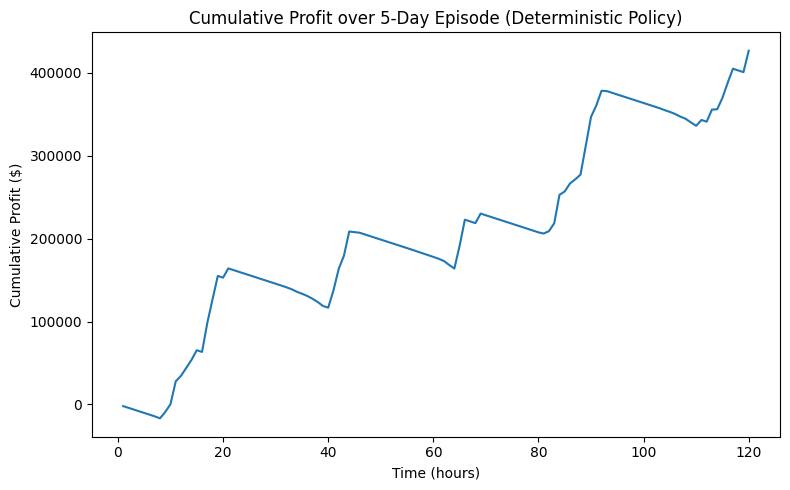

Final 5-day cumulative profit: 426,560 over 120 steps


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(t, cum_profit)
plt.xlabel("Time (hours)")
plt.ylabel("Cumulative Profit ($)")
plt.title("Cumulative Profit over 5-Day Episode (Deterministic Policy)")
plt.tight_layout()
plt.show()

print(f"Final 5-day cumulative profit: {float(cum_profit[-1]):,.0f} over {len(cum_profit)} steps")